# Cloud Coverage Dataset Analysis

- Predicting `total_cloud_coverage_pct` in a short time span of 120 minutes *(where average probability of forecast with <30% error varies between 40% to 60% - [Source](https://arxiv.org/abs/1011.3863))* is very challenging for machine learning.
- On this time scale, changes in local cloud cover are driven by a combination of dynamical and physical parameters such as wind speed, wind direction sea-level pressure, humidity, and temperature over the asset of our interest.
- Short interval cloud cover prediction requires accurate estimates of cloud motion and presence using weather data and sky camera images or physics-based weather models or a combination of both. 

## Goal:
**Predict the percentage of total cloud coverage for the next upcoming intervals using the available weather and sky camera data recorded for 6 hours window.**  

We are expected to predict the total cloud coverage as a percentage of the open sky for a fixed field of view at 4 horizon intervals of 30, 60, 90, and 120 minutes from a 6-hour window of historical data.  

While validating and testing the predictions made by model, we are not supposed to consider **DATE (DD)** and **Time MST** in a day as input features.  
So the task at hand is to make a model which will be generic throughout the year.  

## Exploratory Data Analysis
- Tricky situation that I noticed after going through some images was that, the region where this data was recorded (Not Provided with the dataset so only estimating), is mostly situated around very cold region, where day-night cycle is bit different than middle regions of the Earth.  
- After checking Shell Solar Plant locations, they do have some plants in regions I estimated. So that can help me avoid any bias regarding asian day-night cycle that I have experienced more. 
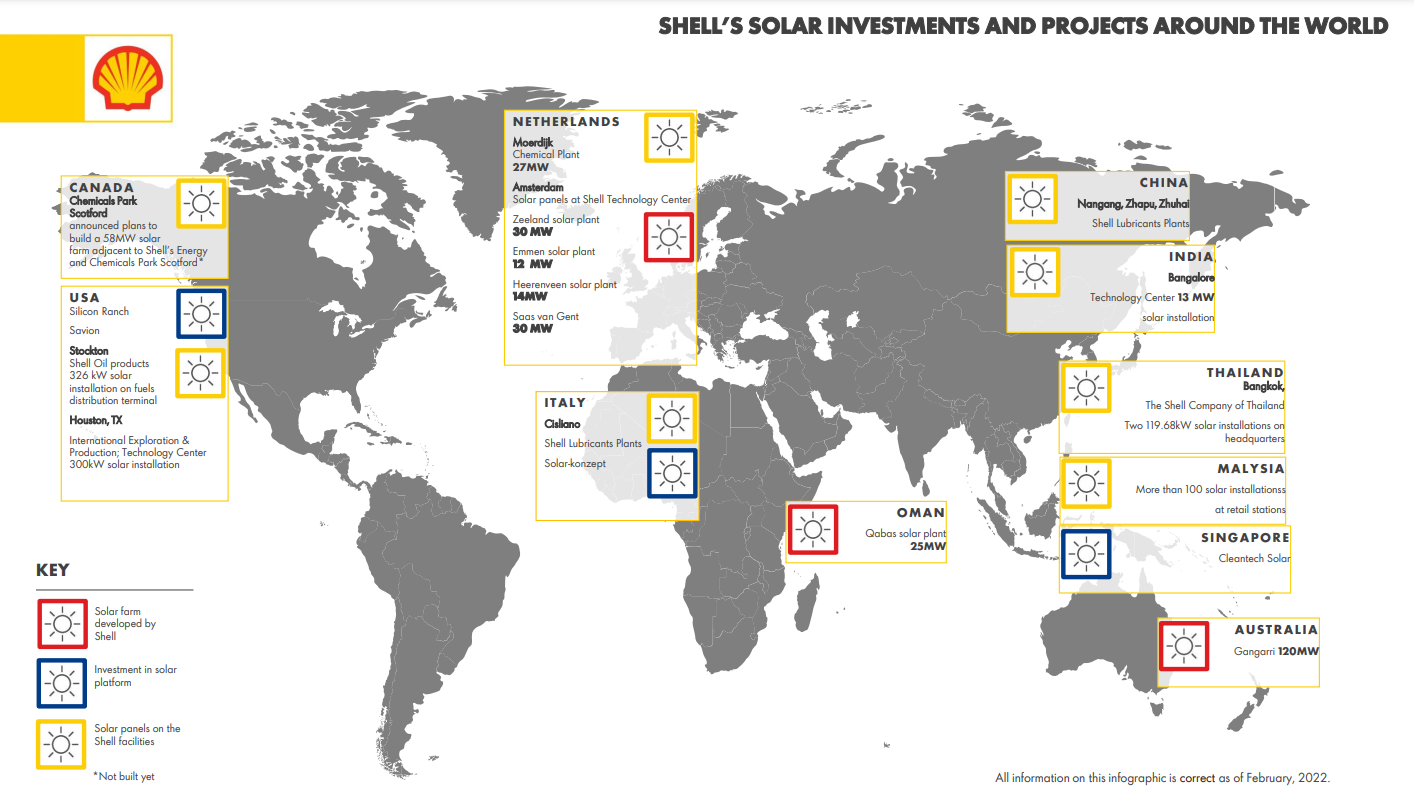

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns

In [2]:
PATH_FOLDER_DATASET = "dataset"
PATH_FOLDER_TRAINING = os.path.join(PATH_FOLDER_DATASET,"train")

Let's import training dataset

In [3]:
weather_df = pd.read_csv(os.path.join(PATH_FOLDER_TRAINING, "train.csv"))
weather_df.head(5)

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0
4,1/1,00:04,-0.934976,-0.054401,0.05415,7.331,1.081,-7.419,31.78,-1,7.20,285.5,806.762,0.0,0.182,0.0,0.0


In [4]:
weather_df.shape

(527040, 17)

The local weather data was recorded for 366 days for 1 minute frequency, this makes $366\times24\times60 = 527040$ rows, which is correct  

## Checking Data Availability
Now the raw sky camera images were recorded at **10 minute frquency** for the same duration. Let's see total number of images

In [5]:
import filetype 

images_count = {}
junks_count = {}

for file in os.scandir(PATH_FOLDER_TRAINING):
    if file.is_dir():
        images_count[file.name] = 0
        junks_count[file.name] = 0
        
        for image in os.scandir(file.path):
            if filetype.is_image(image.path):
                images_count[file.name] += 1
            else:
                junks_count[file.name] += 1

junks_count = np.array(list(junks_count.items()), dtype=object)
images_count = np.array(list(images_count.items()), dtype=object)

In [6]:
print("Junk files in image folder: ", junks_count[np.where(junks_count[:, 1] > 0)])
print("Folders with no images recorded: ", images_count[np.where(images_count[:, 1] == 0)][:,0])

Junk files in image folder:  []
Folders with no images recorded:  ['0404' '0405']


Seems like images were not recorded on 4th & 5th April. Maybe we won't be able to consider weather data for these 2 dates during training. Althugh nothing junk found!  


Since images were captured with 10 mins frquency in a day, let's take a peek at image counts per day for than 8 hours.  
(i.e. less than **48 images** => $\dfrac{8 \times 60}{10}$)

In [7]:
for folder, imagecount in images_count[np.where(images_count[:,1] < 48)]:
    print(f"Folder /{folder} has {imagecount} images")

Folder /0403 has 28 images
Folder /0404 has 0 images
Folder /0405 has 0 images
Folder /0406 has 31 images
Folder /0429 has 11 images
Folder /0506 has 11 images
Folder /0517 has 12 images
Folder /0529 has 14 images
Folder /0712 has 14 images
Folder /0724 has 13 images
Folder /0816 has 11 images
Folder /0912 has 7 images
Folder /0922 has 5 images


Seems for some dates, very few images were captured!

## Analyzing Sensor Data

In [8]:
weather_df.head(3)

,DATE (MM/DD),MST,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Wet Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Moisture,Albedo (CMP11)
0,1/1,00:00,-0.962276,0.0,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.0,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.0,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0


In [9]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527040 entries, 0 to 527039
Data columns (total 17 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   DATE (MM/DD)                           527040 non-null  object 
 1   MST                                    527040 non-null  object 
 2   Global CMP22 (vent/cor) [W/m^2]        527040 non-null  float64
 3   Direct sNIP [W/m^2]                    527040 non-null  float64
 4   Azimuth Angle [degrees]                527040 non-null  float64
 5   Tower Dry Bulb Temp [deg C]            527040 non-null  float64
 6   Tower Wet Bulb Temp [deg C]            527040 non-null  float64
 7   Tower Dew Point Temp [deg C]           527040 non-null  float64
 8   Tower RH [%]                           527040 non-null  float64
 9   Total Cloud Cover [%]                  527040 non-null  int64  
 10  Peak Wind Speed @ 6ft [m/s]            527040 non-null  

### Renaming the features to make them simpler to understand.
I have researched some information about significance of each feature and devices that they were measured from and documented **[here](https://github.com/mrutyunjay17/solar-power-prediction/blob/main/Documentation.md).**

In [10]:
ORIGINAL_FEATURE_NAMES = weather_df.columns

CUSTOM_FEATURE_NAMES = {
    'DATE (MM/DD)':'date',
    'MST':'time',  
    'Global CMP22 (vent/cor) [W/m^2]':'pyranometer',
    'Direct sNIP [W/m^2]':'pyroheliometer',  
    'Azimuth Angle [degrees]':'azimuth_angle_deg',
    'Tower Dry Bulb Temp [deg C]':'tower_dry_bulb_temp_deg', 
    'Tower Wet Bulb Temp [deg C]':'tower_wet_bulb_temp_deg',
    'Tower Dew Point Temp [deg C]':'tower_dew_point_deg', 
    'Tower RH [%]':'tower_rh_pct', 
    'Total Cloud Cover [%]':'total_cloud_coverage_pct',
    'Peak Wind Speed @ 6ft [m/s]':'peak_wind_speed_mps', 
    'Avg Wind Direction @ 6ft [deg from N]':'avg_wind_direction_deg',
    'Station Pressure [mBar]':'station_pressure_mbar', 
    'Precipitation (Accumulated) [mm]':'precipitation_mm',
    'Snow Depth [cm]':'snow_depth_cm', 
    'Moisture':'moisture', 
    'Albedo (CMP11)':'albedometer'
}

In [11]:
weather_df.rename(columns=CUSTOM_FEATURE_NAMES, inplace=True)
weather_df.head(4)

,date,time,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,total_cloud_coverage_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer
0,1/1,00:00,-0.962276,0.000000,356.85640,7.216,0.988,-7.312,32.33,-1,9.95,271.3,806.779,0.0,0.219,0.0,0.0
1,1/1,00:01,-0.937921,0.000000,357.65505,7.251,1.040,-7.260,32.40,-1,8.20,272.9,806.840,0.0,0.206,0.0,0.0
2,1/1,00:02,-0.944395,0.000000,358.45438,7.256,1.093,-7.207,32.54,-1,6.70,288.8,806.876,0.0,0.148,0.0,0.0
3,1/1,00:03,-0.951350,-0.029673,359.25416,7.254,1.060,-7.440,31.89,-1,7.70,294.0,806.823,0.0,0.235,0.0,0.0


Let's check for null values.

In [12]:
weather_df.isnull().sum()

date                        0
time                        0
pyranometer                 0
pyroheliometer              0
azimuth_angle_deg           0
tower_dry_bulb_temp_deg     0
tower_wet_bulb_temp_deg     0
tower_dew_point_deg         0
tower_rh_pct                0
total_cloud_coverage_pct    0
peak_wind_speed_mps         0
avg_wind_direction_deg      0
station_pressure_mbar       0
precipitation_mm            0
snow_depth_cm               0
moisture                    0
albedometer                 0
dtype: int64

Seems like given dataset does not have null values.  

But since most of the features are actually readings from different types of sensors, we need to stay aware of presence of for false reading/device problems/irrelavant reading which may interfare with our model looking for unexpected patterns and hinder prediction performance.  

### Indexing Date Time Columns
**Assumption**:  
Since we are not provided the year when this data was recorded, we'll merge date and time columns and append year as some leap year (data was captured for 1 year = 366 days) to make a single datetime column.

In [13]:
# Merge datetime and get dependant variable as last column
def add_datetime_column(weather_df):
    column_name = 'datetime'
    column_name_cpy = 'datetime_cpy'
    
    if column_name in weather_df.columns: #Already exists
        return weather_df
    
    weather_df[column_name] = pd.to_datetime('2020/'+weather_df['date']+ ' ' + weather_df['time'])
    weather_df[column_name_cpy] = pd.to_datetime('2020/'+weather_df['date']+ ' ' + weather_df['time'])
    weather_df['month'] = weather_df[column_name_cpy].dt.month
    cloud_coverage = weather_df['total_cloud_coverage_pct']
    
    weather_df = weather_df.drop(['date', 'time', 'total_cloud_coverage_pct'], axis=1)
    weather_df['total_cloud_coverage_pct'] = cloud_coverage
    
    weather_df.set_index(column_name, inplace=True)
    return weather_df

In [14]:
weather_df = add_datetime_column(weather_df)
weather_df.head(3)

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,datetime_cpy,month,total_cloud_coverage_pct
datetime,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,-0.962276,0.0,356.85640,7.216,0.988,-7.312,32.33,9.95,271.3,806.779,0.0,0.219,0.0,0.0,2020-01-01 00:00:00,1,-1
2020-01-01 00:01:00,-0.937921,0.0,357.65505,7.251,1.040,-7.260,32.40,8.20,272.9,806.840,0.0,0.206,0.0,0.0,2020-01-01 00:01:00,1,-1
2020-01-01 00:02:00,-0.944395,0.0,358.45438,7.256,1.093,-7.207,32.54,6.70,288.8,806.876,0.0,0.148,0.0,0.0,2020-01-01 00:02:00,1,-1


In [15]:
weather_df.describe()

,pyranometer,pyroheliometer,azimuth_angle_deg,tower_dry_bulb_temp_deg,tower_wet_bulb_temp_deg,tower_dew_point_deg,tower_rh_pct,peak_wind_speed_mps,avg_wind_direction_deg,station_pressure_mbar,precipitation_mm,snow_depth_cm,moisture,albedometer,month,total_cloud_coverage_pct
count,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000
mean,196.971081,237.119295,180.000016,11.829286,4.610521,-3.115536,40.664133,2.855863,168.420883,816.876516,0.370496,-3.301760,0.064295,0.131975,6.513661,-0.592061
std,290.616298,367.803389,100.772041,10.703063,6.965858,7.339865,24.196340,2.081439,116.719968,5.114894,1.871185,199.263767,0.242353,0.186085,3.451237,432.780701
min,-4.764200,-12.403300,0.000120,-16.690000,-17.351000,-24.830000,4.210000,0.000000,0.000000,794.918000,0.000000,-7999.000000,0.000000,0.000000,1.000000,-7999.000000
25%,-1.106560,-0.197818,89.724415,3.222000,-0.877000,-8.653000,22.300000,1.450000,43.280000,813.736000,0.000000,0.102000,0.000000,0.000000,4.000000,-1.000000
50%,4.909625,0.256763,179.991490,11.910000,4.727000,-3.643000,33.790000,2.450000,181.200000,817.305000,0.000000,0.643000,0.000000,0.000000,7.000000,-1.000000
75%,335.747500,518.209250,270.267272,20.350000,10.788000,2.208000,53.530000,3.700000,282.200000,820.278250,0.000000,1.043000,0.000000,0.203600,10.000000,35.000000
max,1428.650000,1069.200000,359.998560,36.320000,19.416000,17.418000,100.100000,24.200000,360.000000,847.963000,28.190000,28.430000,1.000000,2.000000,12.000000,100.000000


### Analyzing Errors in Dataset
#### Falsely Recorded Cloud Coverage Instances
According to metric information, `total_cloud_coverage_pct` should have values **night time=-1** and ranging for **day time= 0 to 100** as per domain knowledge, let's check instances outside these range.

In [70]:
weather_false_coverage_df = weather_df.loc[(weather_df['total_cloud_coverage_pct'] < -1) | (weather_df['total_cloud_coverage_pct'] > 100)]

pd.DataFrame([
    weather_false_coverage_df['total_cloud_coverage_pct'].value_counts() ,
    weather_false_coverage_df['total_cloud_coverage_pct'].value_counts() *100 / weather_df.shape[0]
], index=["Total False Occurances", "% of Total Dataset"])

,-7999,-6999
Total False Occurances,1527.000000,2.000000
% of Total Dataset,0.289731,0.000379


So like I interpreted, I found very few instances which are wrongly recorded as `total_cloud_coverage_pct` either because of device problems or some unknown behaviour.  

To deal with this, maybe we can either think of,  
    
1. As the weather won't change that much significantly in 1 min (maybe want to debate on it more), we can replace the instances with the previous reading of *cloud_coverage_pcts*.  
2. Remove these instances.  
    
Although before replacing the instances with false `total_cloud_coverage_pct`'s, it would be good to look for any patterns so as to how frequently these errors were happening.

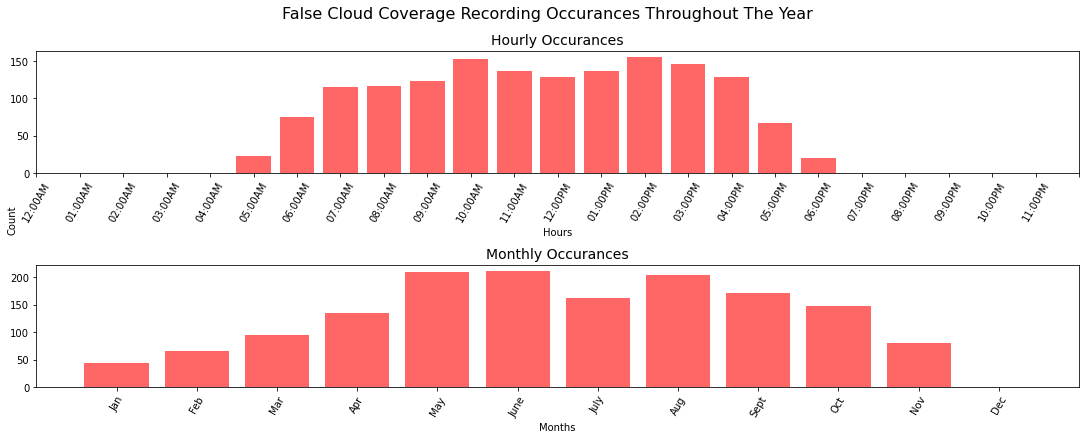

In [71]:
MONTHS = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", 
          "Aug", "Sept", "Oct", "Nov", "Dec"]

HOURS_FMT12 =  ["12:00AM","01:00AM", "02:00AM","03:00AM","04:00AM","05:00AM","06:00AM","07:00AM","08:00AM","09:00AM","10:00AM",
         "11:00AM","12:00PM","01:00PM","02:00PM","03:00PM","04:00PM","05:00PM","06:00PM","07:00PM","08:00PM",
         "09:00PM","10:00PM","11:00PM"," "]

fig, ax = plt.subplots(nrows=2, figsize=(15,6), constrained_layout=True)
fig.suptitle('False Cloud Coverage Recording Occurances Throughout The Year', fontsize=16)
fig.text(0.0, 0.5, 'Count', va='center', rotation='vertical')


# Per Hour
hourly_false_coverage = weather_false_coverage_df.groupby(weather_false_coverage_df["datetime_cpy"].dt.hour)['total_cloud_coverage_pct'].count()
ax[0].bar(x=hourly_false_coverage.index,
        height=hourly_false_coverage.values, color='red', alpha=0.6)
ax[0].set_xlim([0, 23])
ax[0].set_xticks(range(25))
ax[0].set_xticklabels(HOURS_FMT12, rotation=60)
ax[0].set_xlabel("Hours")
ax[0].set_title("Hourly Occurances", fontsize=14)


# Per Month
monthly_false_coverage = weather_false_coverage_df.groupby(weather_false_coverage_df["datetime_cpy"].dt.month)['total_cloud_coverage_pct'].count()
ax[1].bar(x=monthly_false_coverage.index,
        height=monthly_false_coverage.values, color='red', alpha=0.6)
ax[1].set_xlim([0, 13])
ax[1].set_xticks(range(1,13))
ax[1].set_xticklabels(MONTHS, rotation=60)
ax[1].set_xlabel("Months")
ax[1].set_title("Monthly Occurances", fontsize=14)

plt.show()

Here are some of observations about the frequency of occurances of falsely recorded `total_cloud_coverage_pct` I made,  
**Total False Readings - 1,529 (0.3% of the dataset)**
- Hourly - Occurances usually started after 05:00AM , peaked between 08:00AM to 03:00PM and went down till 06:00PM. Since power plant measures cloud coverage only around 5AM - 6PM on average, this does not conclude much information, but only some measurement defect when sun is around it's better position. 
- Monthly - Error occurances peaked between May to August and were lower for rest of the year with exception of December. Now here we are looking at some seasonal effect, that summer time being the better cause of errors.

As these occurances are still widely distributed, like they didn't occure only on certain day for now I replaced the minute $t^{th}$ falsely recorded `total_cloud_coverage_pct` reading with previous minute reading $(t-1)^{th}$.

#### Masking False total_cloud_coverage_pct Readings

In [72]:
#TODO: we can update this condition as generic way to replace total_cloud_coverage_pct < -1 and total_cloud_coverage_pct > 100 
#with their previous correct readings
def replace_false_cloud_coverage_with_previous(weather_df):
    '''
        Replace total_cloud_coverage_pct < -1 with it's previous minute readings.
    '''
    weather_df['total_cloud_coverage_pct'] = weather_df.total_cloud_coverage_pct.mask(weather_df.total_cloud_coverage_pct < -1) \
    .ffill().astype(int)
    return weather_df

In [73]:
weather_df = replace_false_cloud_coverage_with_previous(weather_df)

Let's confirm if the false readings got masked properly

In [74]:
weather_false_coverage_df = weather_df.loc[(weather_df['total_cloud_coverage_pct'] < -1) | (weather_df['total_cloud_coverage_pct'] > 100)]

pd.DataFrame([
    weather_false_coverage_df['total_cloud_coverage_pct'].value_counts() ,
    weather_false_coverage_df['total_cloud_coverage_pct'].value_counts() *100 / weather_df.shape[0]
], index=["Total False Occurances", "% of Total Dataset"])

""
Total False Occurances
% of Total Dataset


### Analyzing Monthly Feature
#### Mean Variation Throughout The Year
Let's see how features vary with respect to Total Cloud Coverage per Month.  

In [75]:
EDA_FEATURES = ['total_cloud_coverage_pct', 'pyranometer', 'pyroheliometer', 
       'tower_dry_bulb_temp_deg', 'tower_wet_bulb_temp_deg',
       'tower_dew_point_deg', 'tower_rh_pct',   'precipitation_mm',
       'snow_depth_cm', 'moisture', 'albedometer']

EDA_LABELS = ['%', '$W/m^2$', '$W/m^2$', '$^{\circ}C$', '$^{\circ}C$', '$^{\circ}C$', '%', 'mm', 'cm', '', '']

In [77]:
import calendar
#from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from matplotlib.colors import Normalize

#COLORS_MONTHS_JAN_DEC = ['#007acc', '#0099ff', '#80ccff', '#b3e0ff', '#ffd1b3', '#ffb380', '#ff751a', '#ff8533', '#ffc299', '#b3e0ff', '#66c2ff', '#33adff']

def plot_feature_variations(weather_df, featurename, ylabel='', aggfunc='mean'):
    '''
        Plotting monthly aggregate of weather feature colored with respect to Monthly Mean total_cloud_coverage_pct.
        
        Note:
            aggfunc - Pandas groupby aggregate function. ex. mean, median, prod, sum, std, var
    '''
    
    temp_df = weather_df.groupby([weather_df.datetime_cpy.dt.month]) \
                    .agg(agg_cloud_coverage = ('total_cloud_coverage_pct', aggfunc), agg_col = (featurename, aggfunc), \
                        mean_cloud_coverage = ('total_cloud_coverage_pct', 'mean'))
    temp_df.index.rename('month', inplace=True)
    temp_df = temp_df.reset_index()
    
    coverage_norm = Normalize(vmin=temp_df['mean_cloud_coverage'].min(), vmax=temp_df['mean_cloud_coverage'].max())
    my_cmap = cm.get_cmap('Blues')
    
    temp_df.plot(kind="bar", x="month", y="agg_col", alpha = 0.8,
             figsize=(14, 2), color=my_cmap(coverage_norm(temp_df['mean_cloud_coverage'])))
    
    if featurename == 'total_cloud_coverage_pct':
        plt.title("{aggfunc} total_cloud_coverage".format(featurename, aggfunc=aggfunc.capitalize()), fontsize=18)
    else:
        plt.title("{aggfunc} {} w.r.t. {aggfunc} total_cloud_coverage".format(featurename, aggfunc=aggfunc.capitalize()), fontsize=14)
    plt.xlabel("")
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks=range(0,12), labels=[calendar.month_name[i] for i in range(1,13)], rotation=70)

Here the color of bar represents mean `total_cloud_coverage`.

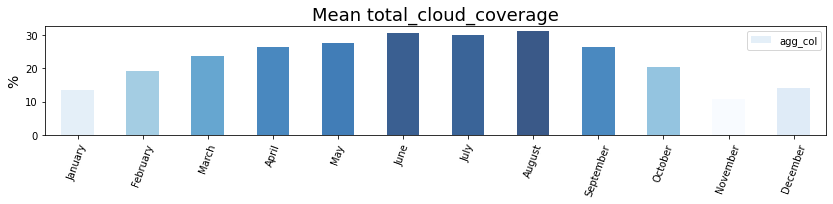

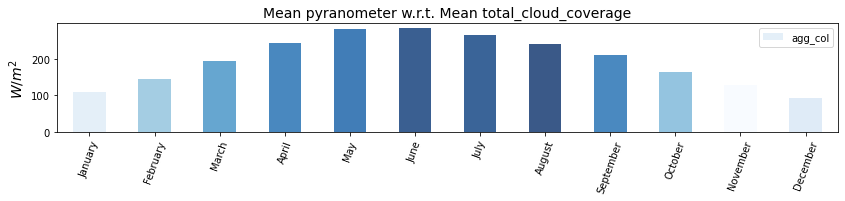

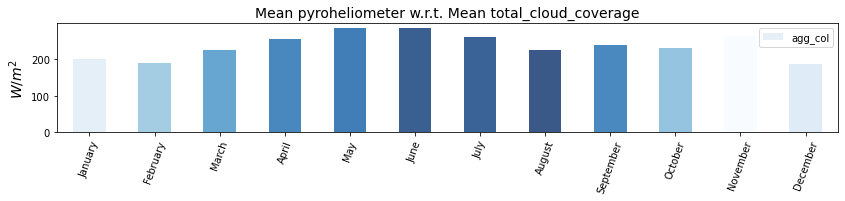

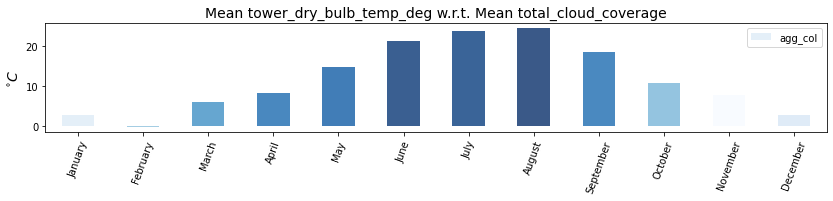

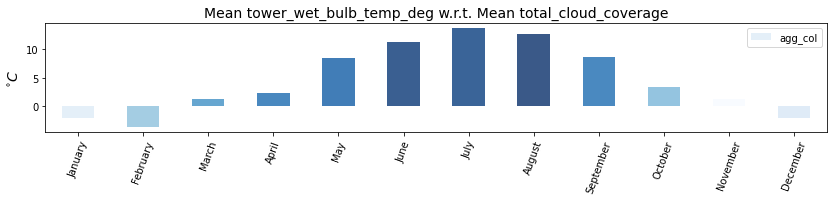

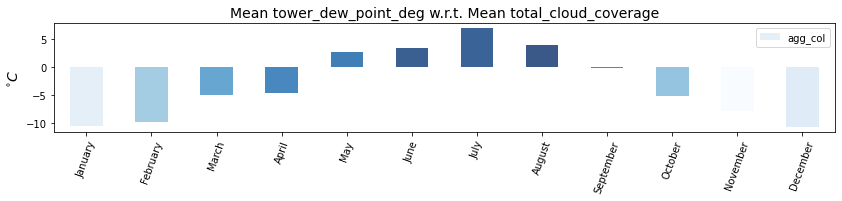

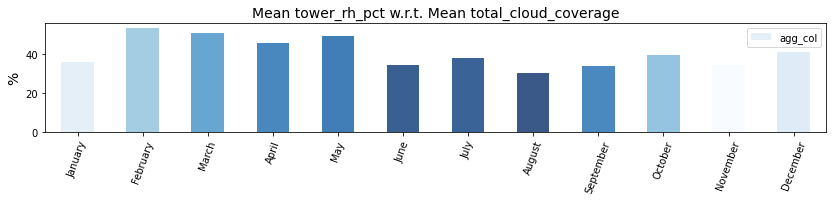

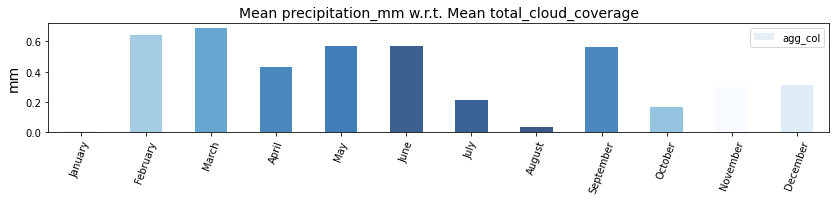

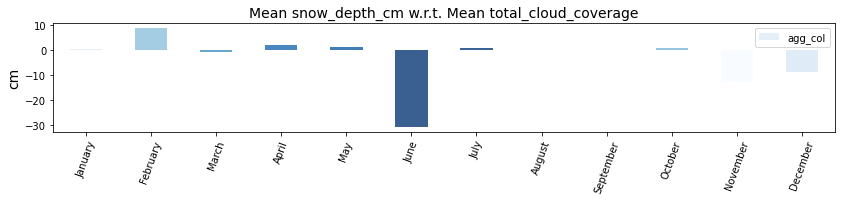

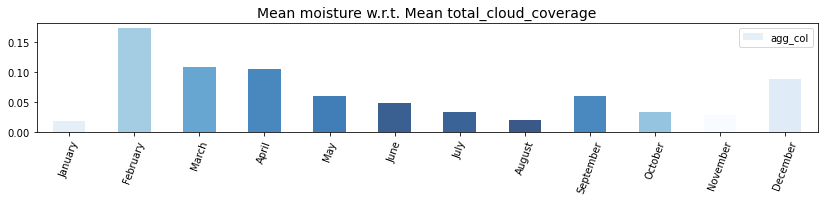

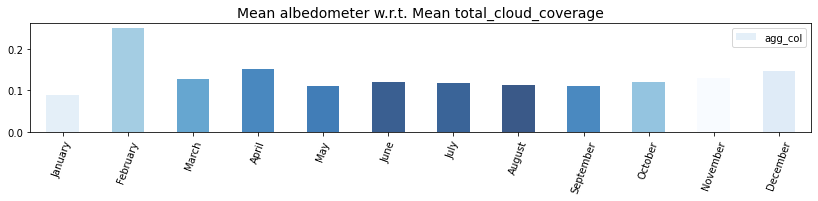

In [78]:
for i, curr_feature in enumerate(EDA_FEATURES):
    plot_feature_variations(weather_df, curr_feature, EDA_LABELS[i], 'mean')

plt.show()

#### Distribution of Features Throughout The Year

In [79]:
import matplotlib as mpl

weather_df['day'] = [date.day for date in weather_df.datetime_cpy] 
weather_df['month'] = [date.month for date in weather_df.datetime_cpy]

In [80]:
MONTH_LABELS = [calendar.month_name[i] for i in range(1,13)]
EDA_FEATURES = ['total_cloud_coverage_pct', 'pyranometer', 'pyroheliometer', 
       'tower_dry_bulb_temp_deg', 'tower_wet_bulb_temp_deg',
       'tower_dew_point_deg', 'tower_rh_pct', 'albedometer']

def draw_month_wise_box(weather_df, featurename, axes, row):
    sns.boxplot(x='month', y=featurename, data=weather_df, ax=axes[row][0])
    sns.boxplot(x='day', y=featurename, data=weather_df, ax = axes[row][1])

    #Set title
    axes[row][0].set_title(f'Monthly {featurename}', fontsize=18)
    axes[row][1].set_title(f'Daily {featurename}', fontsize=18)
    
    axes[row][0].set_xticks(range(0,12)) 
    axes[row][0].set_xticklabels(MONTH_LABELS, rotation=70)

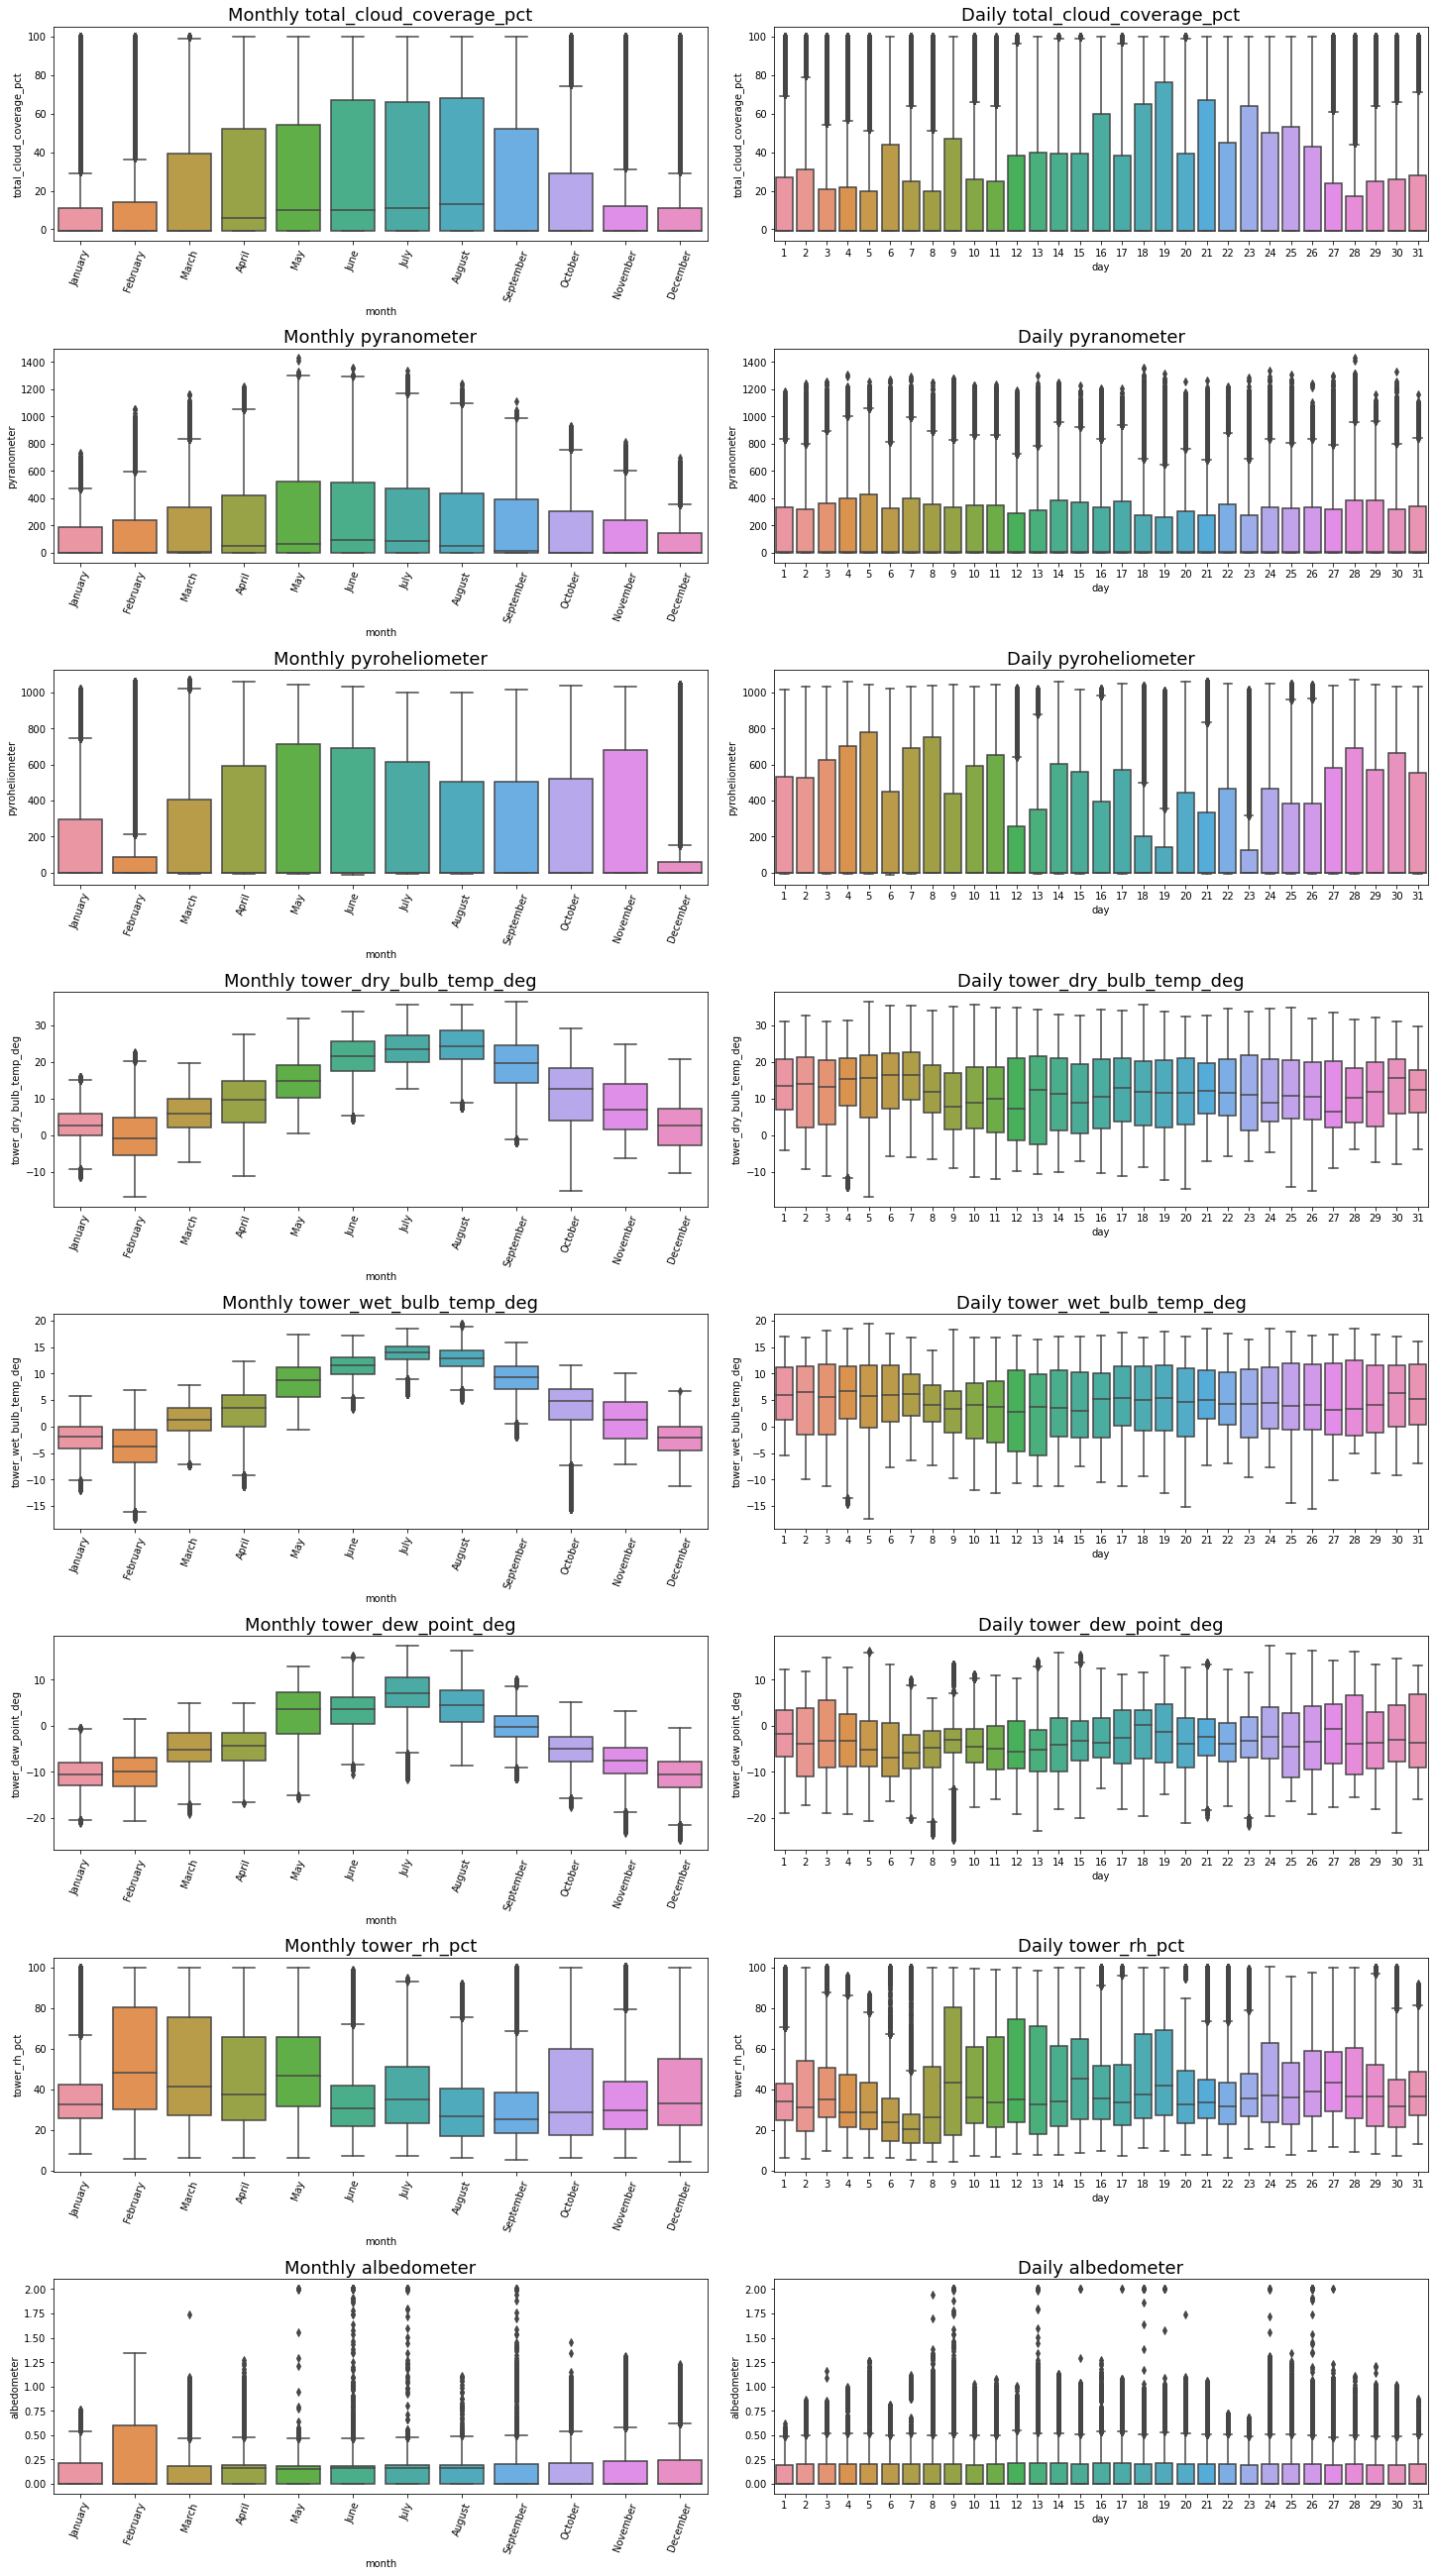

In [81]:
#Draw plot
fig, axes = plt.subplots(8,2, figsize=(20,36), constrained_layout=True)

for row, featurename in enumerate(EDA_FEATURES):
    draw_month_wise_box(weather_df, featurename, axes, row)

plt.show()

Thos does confirms some facts -
- `cloud_coverage` is indeed behaving seasonaly, where it has highest variation with high magnitude around **Spring-Summer** time, and weather is clear during **Autumn-Winter** so lesser clouds.
- Also `pyranometer` readings suggest that, maximum of solar energy is harvested around **Spring-Summer** time with highly varying angular effects of solar power in energy generation as per `pyroheliometer`.
- Also the region has snowfall also during autumn-winter.
- *Negative mean* of `snow_depth` is what I'll need to investigate more.

### Visaulizing Timeseries For a Random Day
Note: Remember timestamps for images may not be available for each 10 mins gap.

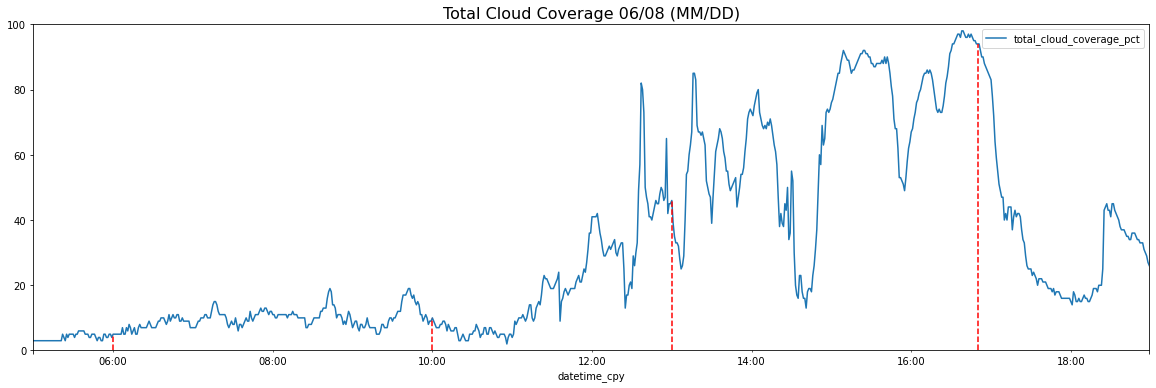

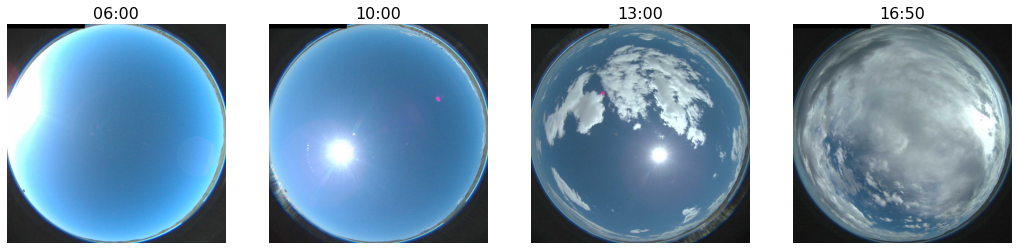

In [185]:
SAMPLE_PICTURE_TIMEFRAMES = ['060000', '100000', '130000', '165000']

day, month = 8,6
sample_day_df = weather_df.loc[weather_df['month'] == month, :].loc[(weather_df['day'] == day) &  
                                                (weather_df.datetime_cpy.dt.hour > 4) & 
                                                (weather_df.datetime_cpy.dt.hour < 19), :]
sample_day_df.plot('datetime_cpy', 'total_cloud_coverage_pct', figsize=(20,6))

for time in SAMPLE_PICTURE_TIMEFRAMES:
    ts_temp = sample_day_df.datetime_cpy[0].replace(month=month, day=day, hour=int(time[:2]), minute=int(time[2:4]))
    height = sample_day_df.loc[ts_temp]['total_cloud_coverage_pct']
    plt.axvline(ts_temp,ymax=height/100, color='red', linestyle='--')
plt.ylim([0,100])
plt.title("Total Cloud Coverage %02d/%02d (MM/DD)" % (month, day), fontsize=16)
plt.show()

fig, ax = plt.subplots(1,4, figsize=(18, 5))

for i, time in enumerate(SAMPLE_PICTURE_TIMEFRAMES):
    try:
        ax[i].imshow(mpimg.imread(f'dataset/train/{month:02d}{day:02d}/{month:02d}{day:02d}{time}.jpg'))
        ax[i].axis('off')
        ax[i].set_title(f'{time[:2]}:{time[2:4]}', fontsize=16)
    except:
        print("Picture Not Available for:",time)
plt.show()

So the images captured and cloud coverage readings are indeed telling the similar story about status of clouds.

## Cloud Coverage - Time Series Analysis

## Summary
So throughout this analysis, I have following findings,
- Dataset was recorded for mostly northern region where Sun can rise around 4 AM and set around 7 PM. Also the region is very cold
- False cloud coverage recordings can be handled mostly using previous value of timestamp, since weather will not change that much in 1 minute timegap.
- Maximum cloud coverage variation was seen in Spring-Summer season.
- Also maximum solar energy was harvested in Spring-Summer season.
- Judging by the weather variations per minute, we can average our records from 1 minute frequency to around 5-15 min frequency to predict cloud coverage.
- We'll estimate effect of cyclic nature using some of the statistical methods for time series analysis.
- Also for the cloud images, maybe we can saparate clear indication of clouds vs rest of the sky with some preprocessing.